<a href="https://colab.research.google.com/github/superbunny38/2021DeepLearning/blob/main/2_Chap_8_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch-2.git original
!mkdir workspace

Cloning into 'original'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 606 (delta 1), reused 5 (delta 0), pack-reused 598
Receiving objects: 100% (606/606), 29.82 MiB | 11.31 MiB/s, done.
Resolving deltas: 100% (361/361), done.


In [2]:
!mv /content/original/common workspace
!mv /content/original/dataset workspace
!mv /content/original/ch07 workspace
!mv /content/original/ch08 workspace

In [3]:
%cd workspace

/content/workspace


가중합 구하기

In [4]:
import numpy as np
T, H = 5,4#시계열 길이, 은닉 상태 벡터의 원소 수
hs = np.random.randn(T,H)
a = np.array([0.8,0.1,0.03,0.05,0.02])

ar = a.reshape(5,1).repeat(4,axis=1)
print(ar.shape)

t = hs*ar
print(t.shape)

c = np.sum(t,axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


미니배치 처리용 가중합

In [5]:
N,T,H = 10,5,4
hs = np.random.randn(N,T,H)
a = np.random.randn(N,T)
ar = a.reshape(N,T,1).repeat(H, axis = 2)

t = hs*ar
print(t.shape)

c = np.sum(t, axis = 1)
print(t.shape)

(10, 5, 4)
(10, 5, 4)


가중합 계산 그래프

In [6]:
class WeightSum:
  def __init__(self):
    self.params, self.grads = [],[]
    self.cache = None
  
  def forward(self, hs,a):
    N, T, H = hs.shape
    ar = a.reshape(N,T,1).repeat(H, axis = 2)
    t = hs*ar

    c = np.sum(t, axis = 1)

    self.cache = (hs,ar)
    return c
  
  def backward(self, dc):
    hs, ar = self.cache
    N,T,H = hs.shape

    dt = dc.reshape(N,1,H).repeat(T, axis = 1)#sum의 역전파
    dar = dt*hs
    dhs = dt*ar
    da = np.sum(dar, axis = 2)#repeat의 역전파

    return dhs, da

Encoder의 LSTM 계층의 은닉상태 벡터인 hs와 Decoder의 LSTM 꼐층의 은닉상태 벡터인 h의 각 단어 벡터가 얼마나 비슷한가를 내적을 통해 수치로 나타내고 softmax 함수로 정규화

In [7]:
import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np

N, T, H = 10,5,4
hs = np.random.randn(N,T,H)
h = np.random.randn(N,H)
hr = h.reshape(N,1,H).repeat(T, axis = 1)

t = hs*hr
print(t.shape)

s = np.sum(t,axis = 2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


In [8]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import Softmax
class AttentionWeight:
  def __init__(self):
    self.params, self.grads = [],[]
    self.softmax = Softmax()
    self.cache = None
  
  def forward(self,hs,h):
    N,T,H = hs.shape
    hr = h.reshape(N,1,H).repeat(T, axis = 1)
    t = hs*hr
    s = np.sum(t, axis = 2)
    a = self.softmax.forward(s)

    self.cache = (hs,hr)
    return a

  def backward(self,da):
    hs, hr = self.cache
    N,T,H = hs.shape

    ds = self.softmax.backward(da)
    dt = ds.reshape(N,T,1).repeat(H, axis = 2)
    dhs = dt*hr
    dhr = dt*hs
    dh = np.sum(dhr, axis =1)
    return dhs, dh

Encoder가 건네주는 정보 hs에서 중요한 원소에 주목하여 그것을 바탕을 맥락 벡터를 구해 위쪽 계층으로 전파

In [9]:
class Attention:
  def __init__(self):
    self.params, self.grads = [],[]
    self.attention_weight_layer = AttentionWeight()
    self.weight_sum_layer = WeightSum()
    self.attention_weight = None
  
  def forward(self, hs, h):
    a = self.attention_layer.forward(hs,h)
    out = self.weight_sum_layer.forward(hs, a)
    self.attention_weight = a
    return out
  
  def backward(self, dout):
    dhs0, da = self.weight_sum_layer.backward(dout)
    dhs1, dh = self.attention_weight_layer.backward(da)
    dhs = dhs0 + dhs1
    return dhs, dh

다수의 Attention 계층을 Time Attention 계층으로 모아 구현

In [10]:
class TimeAttention:
  def __init__(self):
    self.params, self.grads = [],[]
    self.layers = None
    self.attention_weights = None
  
  def forward(self, hs_enc, hs_dec):
    N,T,H = hs_dec.shape
    out = np.empty_like(hs_dec)
    self.layers = []
    self.attention_weights = []

    for t in range(T):
      layer = Attention()
      out[:,t,:] = layer.forward(hs_enc, hs_dec[:,t,:])
      self.layers.append(layer)
      self.attention_weights.append(layer.attention_weight)
    return out
  
  def backward(self, dout):
    N,T,H = dout.shape
    dhs_enc = 0
    dhs_dec = np.empty_like(dout)

    for t in range(T):
      layer = self.layers[t]
      dhs, dh = layer.backward(dout[:,t,:])
      dhs_enc += dhs
      dhs_dec[:,t,:] = dh
    return dhs_enc, dhs_dec

## Attention을 갖춘 seq2seq 구현

In [11]:
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention

In [12]:
class AttentionEncoder(Encoder):
  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)#모든 은닉상태 반환
    return hs
  
  def backward(self, dhs):
    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout

In [13]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)#LSTM 계층의 출력
        c = self.attention.forward(enc_hs, dec_hs)#Time Attention 계층의 출력
        out = np.concatenate((c, dec_hs), axis=2)# 두 출력 연결
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):#새로운 단어열 생성
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


In [14]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [15]:
from common.time_layers import *
from ch07.seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 날짜 형식 변환 문제

In [16]:
import sys
sys.path.append('..')
sys.path.append('../ch07')
import numpy as np
from dataset import sequence
from common.optimizer import Adam

In [17]:
#학습 코드
from common.trainer import Trainer
from common.util import eval_seq2seq

from ch07.seq2seq import Seq2seq

In [18]:
#데이터 읽기
(x_train, t_train),(x_test, t_test) = sequence.load_data('date.txt')

In [19]:
char_to_id, id_to_char = sequence.get_vocab()

In [20]:
#입력 문장 반전
x_train, x_test = x_train[:,::-1],x_test[:,::-1]

In [21]:
#하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

In [22]:
model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [23]:
acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch = 1,
              batch_size = batch_size, max_grad = max_grad)
  correct_num = 0#for acc
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]#?왜지?[[]]?
    verbose = i<10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse = True)
  
  acc = float(correct_num)/len(x_test)
  acc_list.append(acc)
  print('val acc %.3f%%'%(acc*100))
model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 13[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 25[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 38[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 51[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 63[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 75[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 88[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 103[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 117[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 131[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 145[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 161[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 183[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 197[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 210[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 222[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 235[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November

plot accuracy 

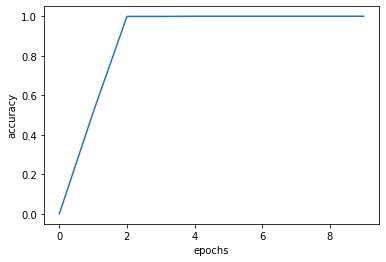

In [24]:
import matplotlib.pyplot as plt
plt.plot(acc_list)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### Visualize Attention

In [25]:
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence

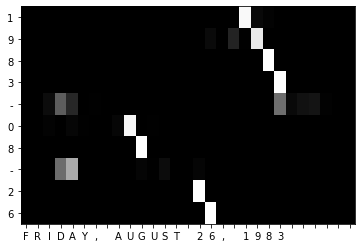

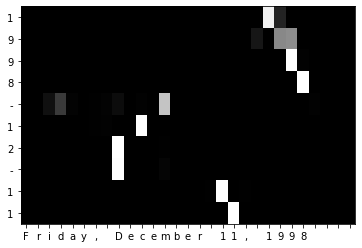

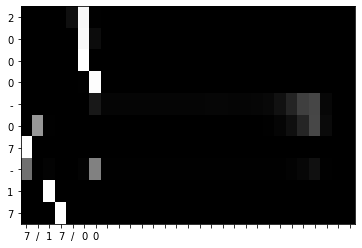

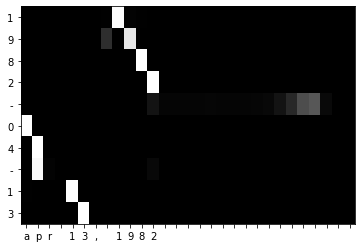

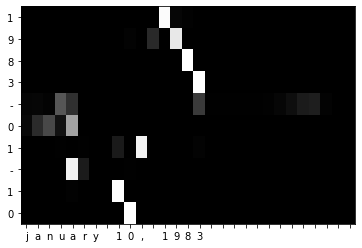

In [26]:

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)#의미있는 것끼리 각각 대응하는걸 알 수 있다